In [63]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)

In [3]:
df.index.freq = 'D'

In [4]:
df.index

DatetimeIndex(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04',
               '1959-01-05', '1959-01-06', '1959-01-07', '1959-01-08',
               '1959-01-09', '1959-01-10',
               ...
               '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25',
               '1959-12-26', '1959-12-27', '1959-12-28', '1959-12-29',
               '1959-12-30', '1959-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq='D')

In [5]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


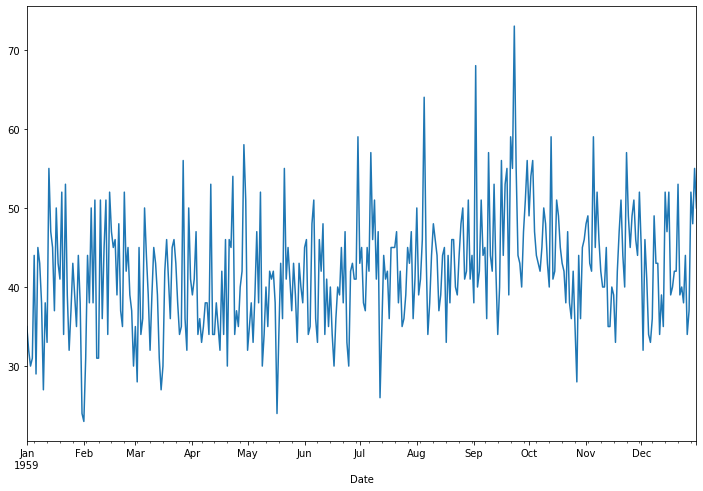

In [6]:
df['Births'].plot(figsize=(12,8))

### ETS Decomposition

In [7]:
result = seasonal_decompose(df['Births'], model='additive');

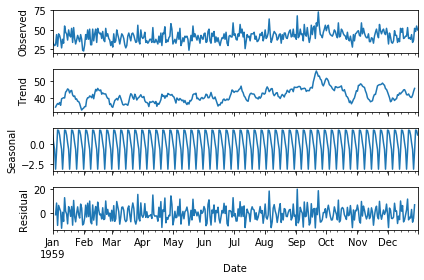

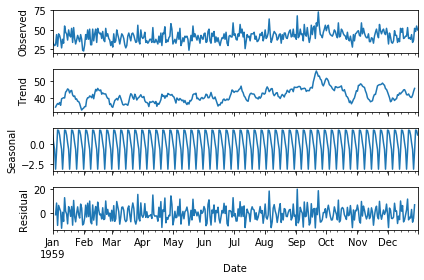

In [8]:
result.plot()

# Automate the augmented Dickey-Fuller Test
### Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [9]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## Run the augmented Dickey-Fuller Test to confirm stationarity

In [10]:
adf_test(df['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Determine the (p,q) ARMA Orders using pmdarima.auto_arima

In [11]:
indentiy_param=auto_arima(df['Births'],seasonal=False,stationary=True,trace=True,start_p=0,max_p=7,start_q=0,max_q=7)

Fit ARIMA: order=(0, 0, 0); AIC=2494.782, BIC=2502.582, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=2479.081, BIC=2490.780, Fit time=0.026 seconds
Fit ARIMA: order=(0, 0, 1); AIC=2482.539, BIC=2494.239, Fit time=0.022 seconds
Fit ARIMA: order=(2, 0, 0); AIC=2476.364, BIC=2491.963, Fit time=0.036 seconds
Fit ARIMA: order=(2, 0, 1); AIC=2466.283, BIC=2485.783, Fit time=0.149 seconds
Fit ARIMA: order=(3, 0, 2); AIC=2469.662, BIC=2496.961, Fit time=0.355 seconds
Fit ARIMA: order=(1, 0, 1); AIC=2468.906, BIC=2484.505, Fit time=0.084 seconds
Fit ARIMA: order=(3, 0, 1); AIC=2467.662, BIC=2491.062, Fit time=0.198 seconds
Fit ARIMA: order=(2, 0, 2); AIC=2467.698, BIC=2491.097, Fit time=0.258 seconds
Total fit time: 1.137 seconds


In [12]:
indentiy_param.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(2, 1)   Log Likelihood               -1228.142
Method:                       css-mle   S.D. of innovations              6.994
Date:                Sun, 29 Mar 2020   AIC                           2466.283
Time:                        15:42:07   BIC                           2485.783
Sample:                             0   HQIC                          2474.033
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7927      1.530     27.309      0.000      38.793      44.792
ar.L1.y        1.1111      0.058     19.131      0.000       0.997       1.225
ar.L2.y       -0.1206      0.055     -2.188      0.029      -0.229      -0.013
ma.L1.y       -0.9535      0.025    -38.723      0.000      -1.002      -0.905
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0109           +0.0000j            1.0109            0.0000
AR.2            8.2026           +0.0000j            8.2026            0.0000
MA.1            1.0488           +0.0000j            1.0488            0.0000
-----------------------------------------------------------------------------
"""

## Reasonable splitting the data train as 80% and test as 20%

In [13]:
size = int(len(df)*0.8)

In [14]:
df_train = df.iloc[:size]

In [15]:
df_test = df.iloc[size:]

## Modelling

In [16]:
model = ARMA(df_train['Births'],order=(2,1))

In [17]:
results = model.fit()

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                  292
Model:                     ARMA(2, 1)   Log Likelihood                -987.482
Method:                       css-mle   S.D. of innovations              7.108
Date:                Sun, 29 Mar 2020   AIC                           1984.964
Time:                        15:42:07   BIC                           2003.348
Sample:                    01-01-1959   HQIC                          1992.328
                         - 10-19-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           42.2922      2.556     16.548      0.000      37.283      47.301
ar.L1.Births     1.0674      0.062     17.197      0.000       0.946       1.189
ar.L2.Births    -0.0730      0.061     -1.201      0.231      -0.192       0.046
ma.L1.Births    -0.9522      0.021    -44.785      0.000      -0.994      -0.910
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0061           +0.0000j            1.0061            0.0000
AR.2           13.6093           +0.0000j           13.6093            0.0000
MA.1            1.0502           +0.0000j            1.0502            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
df.tail()

,Births
Date,
1959-12-27,37
1959-12-28,52
1959-12-29,48
1959-12-30,55
1959-12-31,50


In [20]:
start=len(df_train)
end=len(df_train)+len(df_test)-1
df['forecast'] = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

## Plot predictions against known values

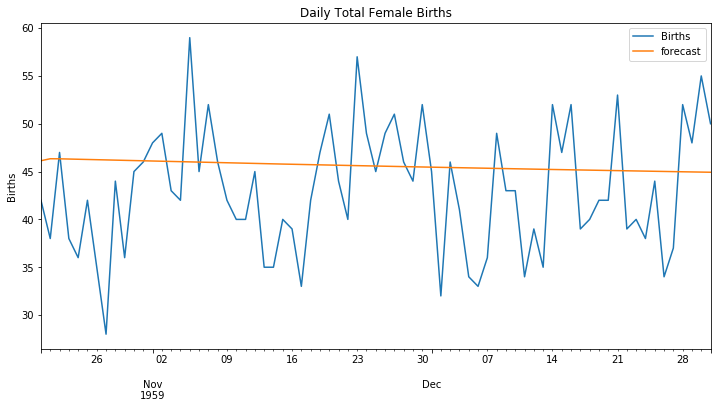

In [21]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = df_test['Births'].plot(legend=True,figsize=(12,6),title=title)
df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [22]:
df

,Births,forecast
Date,,
1959-01-01,35,NaN
1959-01-02,32,NaN
1959-01-03,30,NaN
1959-01-04,31,NaN
1959-01-05,44,NaN
...,...,...
1959-12-27,37,44.994834
1959-12-28,52,44.978393
1959-12-29,48,44.962053


In [23]:
error = rmse(df_test['Births'], df['forecast'].dropna())
print(f'ARMA(2,1) RMSE Error: {error:11.10}')

ARMA(2,1) RMSE Error: 6.973809867


## Retrain the Model

In [24]:
model = ARMA(df['Births'],order=(2,1))

In [25]:
results = model.fit()

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                  365
Model:                     ARMA(2, 1)   Log Likelihood               -1228.142
Method:                       css-mle   S.D. of innovations              6.994
Date:                Sun, 29 Mar 2020   AIC                           2466.283
Time:                        15:42:08   BIC                           2485.783
Sample:                    01-01-1959   HQIC                          2474.033
                         - 12-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.7927      1.530     27.309      0.000      38.793      44.792
ar.L1.Births     1.1111      0.058     19.131      0.000       0.997       1.225
ar.L2.Births    -0.1206      0.055     -2.188      0.029      -0.229      -0.013
ma.L1.Births    -0.9535      0.025    -38.723      0.000      -1.002      -0.905
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0109           +0.0000j            1.0109            0.0000
AR.2            8.2026           +0.0000j            8.2026            0.0000
MA.1            1.0488           +0.0000j            1.0488            0.0000
-----------------------------------------------------------------------------
"""

## Furture 2 Years

In [27]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(x) for x in range(1,30)]

In [28]:
future_dates=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [29]:
future_dates.tail()  ## Future Date 1960-01-01 to 1960-01-29

,Births,forecast
1960-01-25,NaN,NaN
1960-01-26,NaN,NaN
1960-01-27,NaN,NaN
1960-01-28,NaN,NaN
1960-01-29,NaN,NaN


In [30]:
future_dates=pd.concat([df,future_dates])

In [31]:
start = len(df) - 5
end = len(future_dates)

In [32]:
print(start,end)

360 393


In [33]:
future_dates.tail()

,Births,forecast
1960-01-25,NaN,NaN
1960-01-26,NaN,NaN
1960-01-27,NaN,NaN
1960-01-28,NaN,NaN
1960-01-29,NaN,NaN


In [49]:
future_dates['forecast']=results.predict(start = 2, end = end, dynamic= True)

In [50]:
future_dates.tail()

,Births,forecast
1960-01-25,NaN,41.776331
1960-01-26,NaN,41.776508
1960-01-27,NaN,41.776682
1960-01-28,NaN,41.776855
1960-01-29,NaN,41.777026


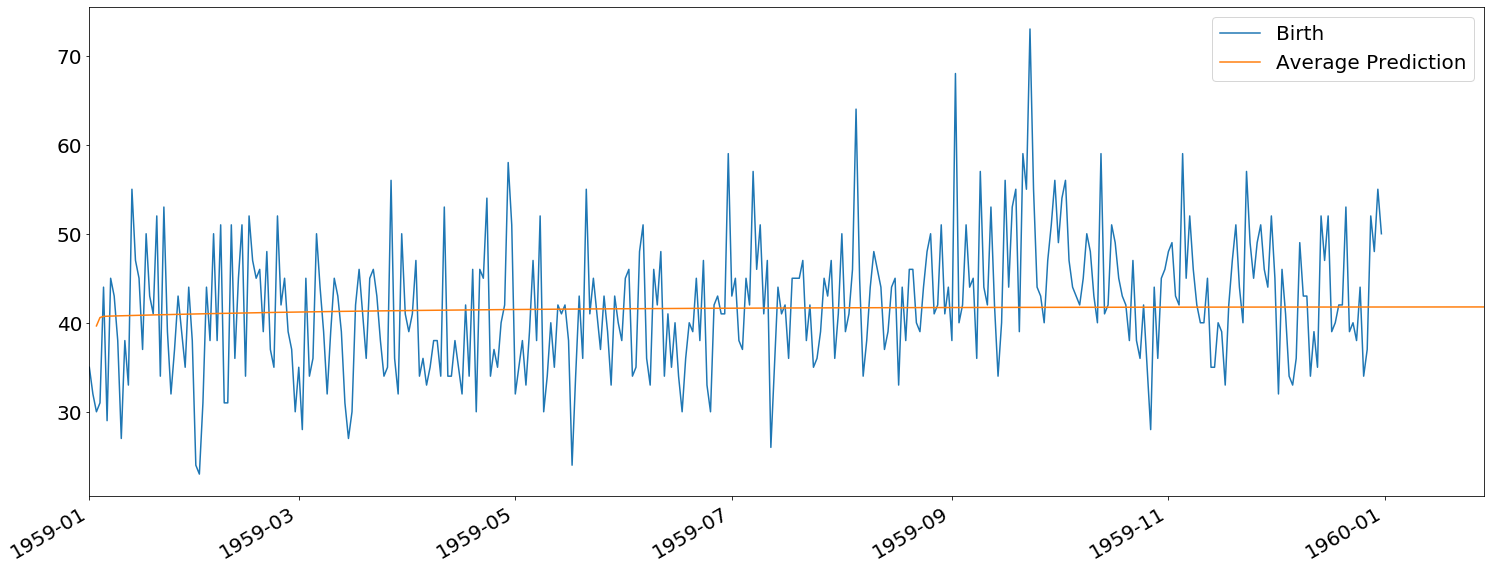

In [72]:

future_dates['Births'].plot(figsize=(25,10),legend = True, Label = "Birth",fontsize=20)
future_dates['forecast'].plot(legend = True,label = "Average Prediction")
plt.legend(["Birth", "Average Prediction"], prop={"size":20})

In [47]:
future_dates.head()

,Births,forecast
1959-01-01,35,NaN
1959-01-02,32,NaN
1959-01-03,30,39.646798
1959-01-04,31,40.589299
1959-01-05,44,40.714354
